In [ ]:
# Show current directory
import os
curr_dir = os.getcwd()
print(curr_dir)
import json
# Define general variables
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder

### HOME PC
# parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"


In [ ]:
# Add parent directory to path (To acess sntt_utils)
import sys

parent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
liset_path = os.path.abspath(os.path.join(curr_dir, '../liset_tk'))


# Add the grandparent directory to the system path
# grandparent_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))
sys.path.append(parent_dir)
sys.path.append(liset_path)
from liset_tk import liset_tk

from liset_aux import ripples_std, middle
from signal_aid import most_active_channel, bandpass_filter

print(sys.path)



# Check if Cuda is available

In [ ]:
import torch
import numpy as np

# Check CUDA Installation
print(torch.cuda.is_available())

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

# Get information about each GPU
for i in range(num_gpus):
    device_props = torch.cuda.get_device_properties(i)
    print(f"\nGPU {i}:")
    print(f"  Name: {device_props.name}")
    print(f"  Total memory: {device_props.total_memory / 1024**3:.2f} GB")
    print(f"  Multiprocessor count: {device_props.multi_processor_count}")
    print(f"  Major compute capability: {device_props.major}")
    print(f"  Minor compute capability: {device_props.minor}")

## Define the Device that will be used to train the SNN


In [ ]:
# Set the device to be used
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")     # torch.device("cpu") #

print("device: ", device)

## Set some important Parameters
`RIPPLE_DETECTION_OFFSET` - based on the time for 4.5 periods of the ripple

`RIPPLE_CONFIDENCE_WINDOW`-

`WINDOW_SIZE` -

`INTERSECT_WINDOW_LEN` - 

`PRED_CAUSALITY_WINDOW` - 

`PRED_GT_TOLERANCE` - 


In [ ]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs
# INTERSECT_WINDOW_LEN = int(MAX_DETECTION_OFFSET)
std, mean = ripples_std(parent) # 61 ms # in seconds
INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

In [ ]:
# Constants for the Refractory LIF Process
confidence_window=int(RIPPLE_DETECTION_OFFSET[1])
# We know that 2 relevant events do not occur within the confidence window of a ripple event, so we set the refractory period accordingly
refrac_period = np.floor(confidence_window / dt)   # Number of time-steps for the refractory period
print("Refractory Period: ", refrac_period, "ms")

# Read the concatenated data and GT

In [ ]:

parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
freq=1000 # Frequency of the data
bandpass=[100,250]
downsampled_fs = 1000 # Downsampled frequency
WINDOW_SHIFT=int(119*downsampled_fs/1000)
WINDOW_SIZE=int(180*downsampled_fs/1000)
time_max=60
window_size=0.05
sample_ratio=0.75
scaling_factor=1
refractory=0

# Generate the SNN's Input Data and Labels (GT)
We need to transform the input data into a format that we can feed into the SNN. To allow learning through BPTT, we will split the spike trains into time windows of WINDOW_SIZE ms. Since a relevant HFO can occur in-between 2 time windows, we will introduce an overlap of INTERSECT_WINDOW_LEN ms between the time windows -- equal to the maximum duration of an HFO.

We are opting for this windowing strategy because it is a simple way to implement learning in the SNN. Another option would be to feed the data in real-time to the SNN without windows, but this would disable the possibility of having batch_size > 1.

# Split the Input into Time Windows and Calculate the Ground Truth

In [ ]:
load=True


from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_data' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,os.pardir,"extract_Nripples","train_pedro","windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # Split the Input Data and Ground Truth into Windows
        windowed_input_data = []    # Input Data Windows
        windowed_gt = []        # Ground Truth Windows (spike time if HFO, -1 if no HFO)
        filtered_windows=[] 
        total_windows_count = 0
        skipped_hfo_count = 0   # Counts the nº of skipped HFOs due to no input activations
        total_hfos=0
        # curr_ripple_times = ripples_concat[curr_ripple_id]    # Get the GT times for the current sEEG source

        # LOAD THE DATA
        # Iterate over the datasets
        for dataset in os.listdir(parent):
            dataset_path = os.path.join(parent, dataset)
            liset= liset_tk(dataset_path, shank=3, downsample=downsampled_fs, verbose=False)

            ripples=np.array(liset.ripples_GT)
            spikified=np.zeros((liset.data.shape[0], liset.data.shape[1], 2))
            filtered=np.zeros((liset.data.shape[0], liset.data.shape[1]))
            thresholds = np.zeros((liset.data.shape[1]))

            print("data shape: ", liset.data.shape)
            print("ripples shape: ", ripples.shape)
            # print("Head of data_concat: ", data[:10][:])
            # print("Head of ripples_concat: ", ripples[:10])
            ripples = ripples[np.argsort(ripples[:, 0])]
            # print(ripples[:10][:])

            for channel in range(liset.data.shape[1]):
                channel_signal = liset.data[:time_max*downsampled_fs, channel]
                filtered_signal=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                thresholds[channel]=round(calculate_threshold(filtered_signal,downsampled_fs,window_size,sample_ratio,scaling_factor),4)

                if thresholds[channel] > 0.1:
                    channel_signal = liset.data[:, channel]
                    curr_ripple_id = 0     # Keep track of the current GT event index since it is monotonically increasing the timestep
                    filtered_liset=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                    spikified[:, channel, :]=up_down_channel(filtered_liset,thresholds[channel],liset.fs,refractory)
                    
                    for i in range(0, liset.data.shape[0], WINDOW_SHIFT*liset.fs):
                        left, right = i, i+WINDOW_SIZE*liset.fs
                        # Get the current input window
                        curr_window = spikified[left:right, channel, :]
                        filtered_window = filtered_liset[left:right]
                        
                        # Increment the total windows count
                        total_windows_count += 1
                        # Check if the current window is smaller than the expected size
                        if curr_window.shape[0] < WINDOW_SIZE:
                            # If the current window is smaller than the expected size, break the loop
                            print(f"[WARNING] Current window [{left}, {right}] is smaller than the expected size. Breaking the loop...")
                            break

                        # OPTIMIZATION STEP: Skip windows with no activations - The gradient will be zero 
                        if np.sum(curr_window) == 0:
                            # print(f"Window [{left}:{right}] has no Input activations. Skipping...")
                            cur_gt_time=[-1, -1]    # Default value for Spike Time (no HFO)
                            if curr_ripple_id < ripples.shape[0]:
                                cur_gt_time = ripples[curr_ripple_id]  
                            if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                                if cur_gt_time[1] <= right:
                                    print(f"[WARNING] Window [{left}:{right}] has a GT event at {cur_gt_time} and NO Input activations. Skipping...")
                                    # Update the curr_gt_idx to the next GT event
                                    skipped_hfo_count += 1
                                curr_ripple_id += 1
                            continue   
                        
                        '''
                        Check if there is a GT event in the current window
                        '''

                        curr_gt = -1    # Default value for Spike Time (no HFO)
                        
                        # Check if the current GT event is within the current window
                        while curr_ripple_id<ripples.shape[0]-1 and ripples[curr_ripple_id][1] < left:
                            # Ripple ends before the window starts → skip it
                            curr_ripple_id += 1
                        
                        if curr_ripple_id >= ripples.shape[0]:
                            curr_ripple_id=ripples.shape[0]-1
                    
                        cur_gt_time = ripples[curr_ripple_id]      
                        if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                            '''
                                Check if the current window overlaps with the current GT event
                                The Network may spike in the interval [GT_time[0], GT_time[0] + MEAN_HFO_DURATION + PRED_GT_TOLERANCE]
                                However, we are using an upper limit for the HFO Duration of WINDOW_SIZE.
                                This way, the Ground Truth Timestamps will be clamped uppwards by WINDOW_SIZE - MAX_HFO_DURATION + MEAN_HFO_DURATION
                            '''
                            if cur_gt_time[1] <= right and cur_gt_time[0]>=left: # If the GT event is completely within the current window
                                '''The Network should predict the HFO -> Calculate the spike time
                                Let's assume the network should spike at the end of the relevant event. We have no way of knowing
                                the exact end time, so we use the mean duration of the event to calculate the spike time.
                                '''
                                avg_spike_time = cur_gt_time[0] +  MEAN_DETECTION_OFFSET # The network should spike at the end of the relevant event
                                
                                # Subtract the left offset to get the spike time in the current window
                                relative_spike_time = avg_spike_time - left
                                if relative_spike_time > WINDOW_SIZE:
                                    # If the spike time is greater than the window size, we want to skip the window
                                    print(f"[WARNING] Spike time {relative_spike_time} is greater than the window size {WINDOW_SIZE}. Adjusting...")
                                    relative_spike_time= cur_gt_time[1]-left

                                curr_gt = relative_spike_time   # Update the curr_gt value

                                # Update the curr_gt_idx to the next GT event
                                curr_ripple_id += 1
                                
                            elif cur_gt_time[1] > right or cur_gt_time[0] < left:
                                continue
                                # If the GT event is not completely within the current window, we want to skip the window
                        
                        # Append the current window    
                        windowed_input_data.append(curr_window)            
                        # Append the current GT Spike Time to the windowed GT
                        windowed_gt.append(curr_gt)
                        filtered_windows.append(filtered_window)
                    total_hfos+=ripples.shape[0]
                else:
                    print(f"[WARNING] Channel {channel} has a very low threshold. Skipping...")
        # Convert to numpy array
        filtered_windows=np.array(filtered_windows, dtype=np.float32)
        windowed_input_data = np.array(windowed_input_data)
        windowed_gt = np.array(windowed_gt, dtype=np.float32)
        removed_windows = total_windows_count - windowed_input_data.shape[0]
        print(f"Removed {removed_windows}/{total_windows_count} ({round((removed_windows / total_windows_count)*100, 2)}%) windows with no input activations")
        print(f"Skipped {skipped_hfo_count} HFOs due to no input activations")
        print(f"Total HFOs (theoretical): {total_hfos}")
else:
    print("Code Block already run. Skipping...")

print("Windowed Input Data Shape: ", windowed_input_data.shape)
print("Windowed GT Shape: ", windowed_gt.shape)
print("Filtered Windows Shape: ", filtered_windows.shape)



# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)


The code block above outputs:

1. A list of time windows of shape =  `(num_windows, window_size, input_neurons) -- windowed_input_data`
2. A list of labels of shape = `(num_windows, ) -- windowed_gt`

In [ ]:
# Define mask for windows with an HFO (spike time >= 0) in the GT

# TODO: Some ripples are detect outside the window - this is not compatible...
# I have changed it to be 180 - might still be too close to the window size
# Mesquita had clamped it differently.

# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")



GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")

**Note**: It's a good sign that the GT time is distributed along the time window.

For example, if the GT annotation could only occur on the first 25% timesteps of the window, it could converge the network toward not spiking or spiking initially to minimize the loss.


**QUESTION** : 
 - How to deal with edge cases? 
 - How to deal with the fact that there are a lot of them at the limit (175-180 ms)

## Interpreting the Ground Truth Timestamp values
- Lower limit: `MEAN_HFO_DURATION`
- Upper limit: `RIPPLE[1]` (actually WINDOW_SIZE)

Such that we only consider the ripples that are completely within the window.

The Marker annotation is a timestamp that indicates the approximated end of the HFO event. It is bounded upwards and downwards by the variables mentioned above.

# Class Balancing
We can see that Class 0 (No HFO) is much more frequent than Class 1 (HFO). This is expected since HFOs are rare events. However, we need to be careful with **class imbalance**, as it can lead to model overfitting and poor generalization.

- 6.51% of Windows -> HFO
- 93.49% of Windows -> No HFO

In [ ]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt, GT_HFO_MASK)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


In [ ]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
intermediate_sorted_indices = np.argsort(
    -(np.sum(intermediate_input[:, :, 0], axis=1) + np.sum(intermediate_input[:, :, 1], axis=1)), 
)

# Sort the input data and GT data by the sorted indices
intermediate_sorted_input = intermediate_input[intermediate_sorted_indices]
intermediate_sorted_gt = intermediate_gt[intermediate_sorted_indices]

print(f"intermediate_sorted_indices: {intermediate_sorted_indices}")
print(f"intermediate_sorted_input: {intermediate_sorted_input.shape} | intermediate_sorted_gt: {intermediate_sorted_gt.shape}")
print(f"intermediate_sorted_gt preview: {intermediate_sorted_gt[:10]}")
print(f"GT first window: {intermediate_sorted_gt[0]} | GT last window: {intermediate_sorted_gt[-1]}")

## Split sorted GT Samples into Time bins to select number of non-HFO Samples

In [ ]:
# Define GT time bins to stratify the GT events
num_bins = 12
# Define bins explicitly to handle the -1 GT
bin_edges = np.linspace(intermediate_sorted_gt[intermediate_sorted_gt >= 0].min(), intermediate_sorted_gt.max(), num_bins)
# Add the -1 bin edge
bin_edges = np.insert(bin_edges, 0, -1.1)   # Add edge below -1
bin_edges = np.unique(bin_edges)   # Remove duplicates
print(bin_edges)

In [ ]:
from pandas import cut
intermediate_binned_gt = cut(intermediate_sorted_gt, bins=bin_edges, labels=False, include_lowest=True)

# Print the number of samples in each bin
unique_bins, unique_counts = np.unique(intermediate_binned_gt, return_counts=True)
print(f"Binned GT Class Distribution: {np.unique(intermediate_binned_gt, return_counts=True)}")
print(f"There are {len(unique_bins)} bins")

`intermediate_binned_gt` is a numpy array of shape (num_bins) containing the index of the GT time bin for each window



In [ ]:
# Get the max. number of elements in a bin excluding the -1 bin
# unique_bins idx 0 is the -1 bin
# Only select MAJORITY_FACTOR * max_bin_size samples with gt=-1
MAJORITY_FACTOR = 3 # 2 # 1 
max_bin_size = int(np.sum(unique_counts[unique_bins > 0]) / MAJORITY_FACTOR) #all ripples
print(f"Max bin size: {max_bin_size}")

In [ ]:
'''
Define Mask for Definitive Windows used
    We will use max_bin_size windows with GT=-1
'''

# Get the indices of the sample windows with gt=-1
ALL_GT_MINUS_1_MASK = intermediate_binned_gt == 0
print(f"Selecting {max_bin_size} samples with GT=-1")
""" 
Since intermediate_sorted_input contains the sorted input data, we can select the first max_bin_size samples with gt=-1.
This way, the selected GT=-1 samples will contain the most UP/DN spikes, forcing the network to differentiate the HFO events
from the non-HFO events with more UP/DN spikes.
"""
GT_MINUS_1_INDICES = np.where(ALL_GT_MINUS_1_MASK)[0][:max_bin_size]
print(f"GT_MINUS_1_INDICES: {GT_MINUS_1_INDICES}")

# Define Mask for the selected indices with GT=-1
GT_MINUS_1_MASK = np.zeros(ALL_GT_MINUS_1_MASK.shape, dtype=bool)   # Create a mask of the same shape as the input data
for selected_idx in GT_MINUS_1_INDICES:
    GT_MINUS_1_MASK[selected_idx] = True   # Set the selected indices to True

# Define Mask for the definitive windows
BALANCED_WINDOWS_MASK = GT_MINUS_1_MASK | (~ALL_GT_MINUS_1_MASK)   # Get the indices some samples with gt=-1 + gt!=-1

# Define the Balanced input and gt data
balanced_input = intermediate_sorted_input[BALANCED_WINDOWS_MASK]
balanced_gt = intermediate_sorted_gt[BALANCED_WINDOWS_MASK]

In [ ]:
# Print the number of samples in each class
print(f"Balanced GT Class Distribution: {np.unique(balanced_gt, return_counts=True)}")
print(f"Balanced Window Input Data Shape: {balanced_input.shape}")
hfo_percent = np.sum(balanced_gt >= 0) / balanced_gt.shape[0] * 100
print(f"Percentage of windows with an HFO: {hfo_percent:.2f}%")
print(f"Baseline Accuracy (No Spiking): {100 - hfo_percent:.2f}%")

In [ ]:
binned_gt = cut(balanced_gt, bins=bin_edges, labels=False, include_lowest=True)

# Print the number of samples in each bin
unique_bins, unique_counts = np.unique(binned_gt, return_counts=True)
print(f"Binned GT Class Distribution: {np.unique(binned_gt, return_counts=True)}")
print(f"There are {len(unique_bins)} bins")

## Split the Data into Training and Testing Sets
Since we split the input into windows, we can use it without worrying about sample order.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Split the data into training and testing
train_proportion = 0.85      # Portion of the data to be used for training

train_data, test_data, train_gt, test_gt = train_test_split(
    balanced_input, balanced_gt,
    train_size=train_proportion, 
    stratify=binned_gt,    # Maintain the class balance based on the labels (balanced_gt)
    shuffle=True
)

print("Training Data Shape: ", train_data.shape)
print("Training Ground Truth Shape: ", train_gt.shape)
print("Testing Data Shape: ", test_data.shape)
print("Testing Ground Truth Shape: ", test_gt.shape)


In [ ]:
# Print the number of input activations in the training and testing data
print("Number of Input Activations in Training Data: ", np.sum(train_data))
print("Number of Input Activations in Testing Data: ", np.sum(test_data))

# Print the Number Annotations in the training and testing data
print("Number of HFO Samples in Training Data: ", np.sum(train_gt >= 0))
print("Number of HFO Samples in Testing Data: ", np.sum(test_gt >= 0))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_gt_tensor = torch.tensor(train_gt, dtype=torch.float32)

test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_gt_tensor = torch.tensor(test_gt, dtype=torch.float32)

In [ ]:
# Create a Tensor Dataset
train_dataset = TensorDataset(train_data_tensor, train_gt_tensor)
test_dataset = TensorDataset(test_data_tensor, test_gt_tensor)

# Define the batch size
batch_size = 2  # 2

# Create Data Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,   # Do we want to force training one by one, i.e., batch_size=1?
    shuffle=True,   # TODO: We are shuffling because each window resets the state of the network so it should not matter. Might not be the case for RNNs!!
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:

# Show how many batches are in the training and testing data
print("Number of Training Batches: ", len(train_loader))
print("Number of Testing Batches: ", len(test_loader))

## Define the Network
### Define the Loss Function

In [ ]:
from snntorch import functional as SF
from snnTorch.utils.loss import mse_temporal_loss_penalty, first_spike_acc

'''
Define the loss function
Let's use the mse_temporal_loss - Mean Squared Error Loss Temporal Loss.

Forward function:
Parameters:
    - output: Predictions of the network - First spike time of each output neuron.
        shape: torch.Tensor shape=(batch_size, num_classes) 
    - target:  Ground truth of the network - First spike time of each output neuron.
        shape: torch.Tensor shape=(batch_size, num_timesteps)
Returns:
    - loss: The loss value 
        shape: torch.Tensor shape=()

The loss function calculates the MSE loss of the first spike time of each output neuron.
If the output neuron spikes within the tolerance window, the loss is 0.
If the output neuron does not spike -> Considers it to spike at the last timestep and calculates the loss accordingly.
Note: The spike time is divided by the number of timesteps to normalize it between 0 and 1 -> Loss gets pretty low values
'''
PENALTY_FACTOR = 1     # 1.5  # 1    # Penalty factor for the loss function (Extreme cases)


loss_fn = mse_temporal_loss_penalty(
    # target_is_time=True -> Target is the spike time (time step) of each output neuron. If false, the target is the gt class and the spike time of each class is fixed
    target_is_time=True,
    tolerance=PRED_GT_TOLERANCE,       # Tolerance for the mse loss (in timesteps). If the output neuron spikes within this tolerance, the loss is 0
    reduction='mean',        # Average the loss across the batch
    penalty_factor=PENALTY_FACTOR,
    normalize=False, # True      # Whether to normalize the loss by the number of timesteps 
)

""" loss_fn = SF.mse_temporal_loss(
    target_is_time=True,
    tolerance=PRED_GT_TOLERANCE,       # Tolerance for the mse loss (in timesteps). If the output neuron spikes within this tolerance, the loss is 0
    reduction='mean'  # 'mean',          # Average the loss across the batch OR Sum the loss across the batch
) """

##  Define the Parameters of the Layers


In [ ]:
import snntorch as snn
import torch.nn as nn
from snntorch import surrogate

# Global Parameters
v_thr = 1.0

# Define the surrogate gradient function to propagate spikes through the network
spike_grad = surrogate.fast_sigmoid()   # surrogate.atan()  # TODO: Try other surrogate from paper   

# Parameters for LIF neurons
# TODO: Make parameters learnable or at least distribute them in a better way

# Define the distribution for the parameters (alpha and beta)
alpha_mean, alpha_std = 0.5, 0.2    
beta_mean, beta_std = 0.5, 0.2

In [ ]:
# Parameters for Dense Layers
inputDataDim = 2 # UP DN   # max_channel_idx - min_channel_idx + 1    # Number of input channels

input_to_hidden = (inputDataDim, 24) # 24 # 16 # TODO: Increase the size of this layer # (inputDataDim, 100) # (inputDataDim, 500)  # Number of neurons in the first Fully-Connected Layer

hiddenL2Dim = (input_to_hidden[1], input_to_hidden[1])  # Number of neurons in the Recurrent Fully-Connected Layer (L2)

hiddenL3Dim = (input_to_hidden[1], 16)  # 16 # Number of neurons in the Fully-Connected Layer (L3)

hiddenL4Dim = (hiddenL3Dim[1], input_to_hidden[1])  # Number of neurons in the Recurrent Fully-Connected Layer (L4)

hidden_to_out = (hiddenL3Dim[1], 1)  # Number of neurons in the Output Fully-Connected Layer
# In this case, we only need 1 output neuron -> Fires when HFO is detected

In [ ]:
# Generate a random distribution for the current and membrane decays
alpha_lif1 = torch.normal(mean=torch.full(size=(input_to_hidden[1],), fill_value=alpha_mean), std=torch.full(size=(input_to_hidden[1],), fill_value=alpha_std))
beta_lif1 = torch.normal(mean=torch.full(size=(input_to_hidden[1],), fill_value=beta_mean), std=torch.full(size=(input_to_hidden[1],), fill_value=beta_std))
alpha_lif2 = torch.normal(mean=torch.full(size=(hiddenL3Dim[1],), fill_value=alpha_mean), std=torch.full(size=(hiddenL3Dim[1],), fill_value=alpha_std))
beta_lif2 = torch.normal(mean=torch.full(size=(hiddenL3Dim[1],), fill_value=beta_mean), std=torch.full(size=(hiddenL3Dim[1],), fill_value=beta_std))

# Clip the value to be positive
TIME_CONSTANT_MIN = 1e-2
TIME_CONSTANT_MAX = 0.99
alpha_lif1 = torch.clamp(alpha_lif1, min=0.05, max=0.95)
beta_lif1 = torch.clamp(beta_lif1, min=0.05, max=0.95)
alpha_lif2 = torch.clamp(alpha_lif2, min=0.05, max=0.95)
beta_lif2 = torch.clamp(beta_lif2, min=0.05, max=0.95)

# TODO: Check these values?
alpha_lif_out = 0.5
beta_lif_out = 0.5

# Print the parameters
print(f"LIF1 Alpha: {alpha_lif1} |\nBeta: {beta_lif1} |\n Shape: {alpha_lif1.shape}")
print(f"\nLIF2 Alpha: {alpha_lif2} |\nBeta: {beta_lif2} |\n Shape: {alpha_lif2.shape}")
print(f"\nLIF OUT Alpha: {alpha_lif_out} | Beta: {beta_lif_out}")

## Define the Network

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        
        # Create a Linear Layer to serve input to LIF1
        self.fc_in = nn.Linear(input_to_hidden[0], input_to_hidden[1],
                bias=False,
                dtype=torch.float32     # Set the data type of the weights to float32
        )

        # TODO: Should the LIF neurons be able to get a negative membrane potential? I think so?
        self.lif1 = snn.Synaptic(
            alpha=alpha_lif1, beta=beta_lif1, threshold=v_thr,
            reset_mechanism="zero", reset_delay=False,
            # TODO: How to add Refractory Period?
            # init_hidden=True,   # enables the methods in snntorch.backprop to automatically clear the hidden states and detach them from the comp. graph
            spike_grad=spike_grad,
            learn_alpha=True,   # Learn the alpha parameter
            learn_beta=True,    # Learn the beta parameter
            learn_threshold=False,   # Learn the threshold parameter
        )      

        """ self.fc2 = nn.Linear(
            hiddenL2Dim[0], hiddenL2Dim[1],
            bias=False,
            dtype=torch.float32     # Set the data type of the weights to float32
        ) """

        self.fc3 = nn.Linear(
            hiddenL3Dim[0], hiddenL3Dim[1],
            bias=False,
            dtype=torch.float32     # Set the data type of the weights to float32
        )

        self.lif2 = snn.Synaptic(
            alpha=alpha_lif2, beta=beta_lif2, threshold=v_thr,
            reset_mechanism="zero", reset_delay=False,
            # TODO: How to add Refractory Period?
            # init_hidden=True,   # enables the methods in snntorch.backprop to automatically clear the hidden states and detach them from the comp. graph
            spike_grad=spike_grad,
            learn_alpha=True,   # Learn the alpha parameter
            learn_beta=True,    # Learn the beta parameter
            learn_threshold=False,   # Learn the threshold parameter
            # inhibition=True,   # If true, surpresses all spiking other than the neuron with the highest potential
        ) 

        """ self.fc4 = nn.Linear(
            hiddenL4Dim[0], hiddenL4Dim[1],
            bias=False,
            dtype=torch.float32     # Set the data type of the weights to float32
        ) """

        self.fc_out = nn.Linear(
            hidden_to_out[0], hidden_to_out[1],
            bias=False,
            dtype=torch.float32     # Set the data type of the weights to float32
        )

        self.lif_out = snn.Synaptic(
            alpha=alpha_lif_out, beta=beta_lif_out, threshold=v_thr,
            reset_mechanism="zero", reset_delay=False,
            # init_hidden=True,   # enables the methods in snntorch.backprop to automatically clear the hidden states and detach them from the comp. graph
            spike_grad=spike_grad,
            learn_alpha=True,   # Learn the alpha parameter
            learn_beta=True,    # Learn the beta parameter
            learn_threshold=False,   # Learn the threshold parameter
            # inhibition=True,   # If true, surpresses all spiking other than the neuron with the highest potential
        )
        
    """
    Function called during the forward pass of the network
    """
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        Forward Pass of the Network

        Parameters:
        - x: input tensor. Shape: (batch_size, num_steps, num_features)

        Returns:
        - spk_rec: tuple of tensors containing the spikes of the neurons
        - mem_rec: tuple of tensors containing the membrane potentials of the neurons
        - cur_rec: tuple of tensors containing the currents of the neurons
        '''
        '''
        print(f"Input Shape: {x.shape}")
        Get the batch size and input data dimension
        '''
        cur_batch_size, cur_num_steps, cur_num_channels = x.shape

        # Reset the hidden states of the neurons (membrane potentials, currents, and spikes)
        syn1, mem1 = self.lif1.reset_mem()
        syn2, mem2 = self.lif2.reset_mem()
        syn_out, mem_out = self.lif_out.reset_mem()

        # Define small residual for spk1
        #TODO : Check if this is necessary...
        spk1_factor = 0.01
        spk1 = torch.rand(size=(cur_batch_size, input_to_hidden[1]), dtype=torch.float32, device=device) * spk1_factor
        spk2 = torch.zeros(size=(cur_batch_size, hiddenL3Dim[1]), dtype=torch.float32, device=device) * spk1_factor
        spk_out = torch.zeros(size=(cur_batch_size, hidden_to_out[1]), dtype=torch.float32, device=device)
        # preview_np_array(spk1, "spk1", edge_items=5)
        
        # Record the neuron's spikes, membrane potentials and currents for each Neuron Layer
        # Shape of each Rec: (num_lif_layers=2, num_steps, batch_size, num_neurons)
        cur_rec: tuple[torch.Tensor[float], torch.Tensor[float], torch.Tensor[float]] = ([], [], [])
        mem_rec: tuple[torch.Tensor[float], torch.Tensor[float], torch.Tensor[float]] = ([], [], [])
        spk_rec: tuple[torch.Tensor[float], torch.Tensor[float], torch.Tensor[float]] = ([], [], [])

        # TODO: Here, having + PRED_CAUSALITY WINDOW MIGHT NOT BE NECESSARY?
        # NOTE: I think it is, to assure the LIF neurons have time after the actual event time
        # to update their inner state and be able to spike.
        
        for step in range(WINDOW_SIZE + PRED_CAUSALITY_WINDOW):         #  
            # Define the default input for step > WINDOW_SIZE
            # No actiation after the window size (only to include network updates for the PRED_CAUSALITY_WINDOW)
            curr_input = torch.zeros(size=(cur_batch_size, cur_num_channels), dtype=torch.float32, device=device)

            if step < WINDOW_SIZE:
                # Get the current input from x

                # curr_input Shape: (batch_size, num_channels)
                curr_input = x[:, step, :]     # Get the current input for all the batch elements
            
                if len(curr_input.shape) == 1:
                    # If the input is 1D, it means we have only one feature (one channel)
                    # Unsqueeze the input to add the num_features dimension
                    curr_input = curr_input.unsqueeze(1)

            
            ############# State Update #############
            # Calculate Input Current for LIF1 from the Input Layer (FC1) Input -> LIF1
            cur_fc_in = self.fc_in(curr_input) 
        
            # Calculate Input Current from Recurrent Layer (FC2) LIF1 -> LIF1
            # cur_fc2 = self.fc2(spk1)   # Connect LIF1 to itself using FC Layer 2 (Recurrent Layer)

            # Calculate Input Current From Recurrent Layer (FC4) LIF2 -> LIF1
            # cur_fc4 = self.fc4(spk2)    # Connect LIF2 to LIF1 using FC Layer 4 (Recurrent Layer)

            # Join the input currents for LIF1 (FC1 + FC2)
            cur1 = cur_fc_in # + cur_fc4  # + cur_fc2  # TODO: Not feeding Recurent Layer to LIF1 for now

            # Feed the joined input current to LIF1
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)  # Feed input to LIF1

            # Calculate Input Current for LIF2 from LIF1 (FC3) LIF1 -> LIF2
            cur2 = self.fc3(spk1)   # Connect LIF1 to LIF2 using FC Layer 3
            # Feed the input current to LIF2 and get the spikes, synaptic currents and membrane potentials
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)  # Feed input to LIF2

            # Calculate Input Current for LIF_OUT from LIF2 (FC4) LIF2 -> LIF_OUT
            cur_out = self.fc_out(spk2)
            # Feed the input current to LIF_OUT and get the spikes, synaptic currents and membrane potentials
            spk_out, syn_out, mem_out = self.lif_out(cur_out, syn_out, mem_out)  # Feed input to LIF_OUT

            # Record the currents, membrane potentials and spikes
            cur_rec[0].append(cur1), cur_rec[1].append(cur2), cur_rec[2].append(cur_out)
            mem_rec[0].append(mem1), mem_rec[1].append(mem2), mem_rec[2].append(mem_out)
            spk_rec[0].append(spk1), spk_rec[1].append(spk2), spk_rec[2].append(spk_out)

        # Return the recorded currents, membrane potentials and spikes
        # Convert the lists to tensors and stack them along the first dimension
        cur_rec = tuple([torch.stack(cur, dim=0) for cur in cur_rec])
        mem_rec = tuple([torch.stack(mem, dim=0) for mem in mem_rec])
        spk_rec = tuple([torch.stack(spk, dim=0) for spk in spk_rec])

        # TODO: Check if the dimensions are correct
        return (
            spk_rec, mem_rec, cur_rec, 
        )

The code in the `forward()` function will only be called once the input argument x is explicitly passed to the network.



In [ ]:
recurrent_layers = ["fc2", "fc4"]  # List w/ name of recurrent layers
positive_bias = [   # List w/ name of layers that should have positive bias in the weights
    # "fc_in",
    "fc3",
    "fc_out"
]  
POSITIVE_INC = 0.4

def weight_init(net: Net):
    '''
    Initialize the weights of the network (Linear Layers)

    Parameters:
        net: The network to initialize
    '''
    linear_layer_idx = 0

    # Iterate over the Linear Layers in the network
    for name, layer in net.named_children():
        # print(f"Layer: {name} - {layer}")
        if isinstance(layer, nn.Linear):
            # print(f"Layer: {layer.in_features } -> {layer.out_features}")
            if name in recurrent_layers:
                # Second linear layer (Recurrent Layer) -> Initialize the weights using orthogonal initialization
                # Orthogonal initialization is used to promote stable gradient propagation and prevent vanishing/exploding gradients
                nn.init.orthogonal_(layer.weight)
            elif name in positive_bias:
                nn.init.xavier_normal_(layer.weight)

                with torch.no_grad():

                    # Create a mask for incrementable weights
                    INTERVAL_WEIGHTS_MASK = (layer.weight.data >= 0) & (layer.weight.data < (1 - POSITIVE_INC))
                    # Offset the weights to be positive
                    layer.weight.data[INTERVAL_WEIGHTS_MASK] += POSITIVE_INC
            else:
                # If it's not the first linear layer, initialize the weights between -1 and 1
                # nn.init.uniform_(layer.weight, a=-1, b=1)
                nn.init.xavier_normal_(layer.weight)

            # Increment the linear layer index
            linear_layer_idx += 1

In [ ]:
# Load the network onto CUDA if available
net = Net().to(device)

# Initialize the weights of the network
weight_init(net)

# print the network
print(net)

In [ ]:
# Save the Initial network to a file to preserve the initial weights
SAVE_NETWORK = False
if SAVE_NETWORK:
    torch.save(net.state_dict(), "./out/hfo/initial_weights.pth")

In [ ]:
# Load the Initial network from a file
LOAD_NETWORK = False
# TODO: Initial weights don't have to be loaded? Could just be random
if LOAD_NETWORK:
    net.load_state_dict(torch.load("./out/hfo/initial_weights.pth"))

In [ ]:
# Display the network architecture
untrained_params = []
untrained_total_params = 0
# Iterate through the layers of the network
for idx, (name, param) in enumerate(net.named_parameters()):
    # Add the parameter to the list of untrained parameters
    untrained_params.append(param.clone())

    # print("param: ", param)
    if param.shape == torch.Size([]):
        print(f"Scalar Param ({name}) | Shape={param.shape} | Value={param} \n")
    elif len(param.shape) == 1:
        print(f"Vector Param ({name}) | Shape={param.shape} | Value={param} \n")
    else:
        print(f"Tensor Param ({name}) | Shape={param.shape}. Total={param.numel()} Preview: {param}\n")

    # Add the number of parameters in the layer to the total
    untrained_total_params += param.numel()

# Print the total number of parameters in the network
print(f"Total Parameters: {untrained_total_params}")

## Define the Optimizer


In [ ]:
'''
Define the Learning Rate.
Using a LR based on the window size, since our loss function is also dependent on the window size.
Another alternative is to normalize the loss function by the window size.
'''
learning_rate = 1e-4   # (1 / (WINDOW_SIZE**2)) # 5e-1   #1e-2    # 1e-1   # (1 / (WINDOW_SIZE**2)) * 10 # * 1e-1    # * 10    # 1e-3 # 1e-1

# Define Learning Rate for Alpha and Beta Parameters
time_constant_params = {
    "params": [net.lif1.alpha, net.lif1.beta, net.lif2.alpha, net.lif2.beta, net.lif_out.alpha, net.lif_out.beta],
    "lr": learning_rate # * 0.1,   # Make these parameters learn slower than the weights
}   # * 10
increased_lr_params = {
    "params": [net.fc_in.weight],
    "lr": learning_rate * 5,   # Make these parameters learn faster than the default
}
other_params = {
    "params": [param for name, param in net.named_parameters() if name not in ["lif1.alpha", "lif1.beta", "lif2.alpha", "lif2.beta", "lif_out.alpha", "lif_out.beta", "fc_in.weight"]],
    "lr": learning_rate,   # Default learning rate
}

param_groups = [
    time_constant_params,
    increased_lr_params, 
    other_params
]

print(f"Number of time constant params: {len(time_constant_params['params'])}")
print(f"Number of increased LR params: {len(increased_lr_params['params'])}")
print(f"Number of other params: {len(other_params['params'])}")

In [ ]:
'''
# The Adam Optimizer is an adaptive learning rate optimization algorithm
# that is based on the adaptive estimation of first-order and second-order moments.
# The learning rate is defined for each parameter and is updated during training.
# NOTE: Should I define the learning rate for each layer parameters separately?
'''

# optimizer = torch.optim.Adam(
#     param_groups, lr=learning_rate,
#     betas=(0.9, 0.999),  # TODO: What are these betas? How much past gradients influence the current gradient? How much past squared gradients influence the current gradient?
#     weight_decay=0   # Pushes the weights towards 0 (L2 Regularization)
# )  

optimizer = torch.optim.SGD(
    param_groups, lr=learning_rate,
    weight_decay=0,
    momentum=0,      # 0.6, # Note: setting to 0 to simplify the optimizer
    dampening=0
)

# Define a scheduler for the learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.8   # Decrease the learning rate by 10% every epoch
)

print(f"learning_rate: {learning_rate}")

In [ ]:
# Print the learning rate for each parameter group
for group_idx, param_group in enumerate(optimizer.param_groups):
    print(f"Param Group {group_idx} | Learning Rate: {param_group['lr']}")
    # Show parameters shape inside this group
    for param in param_group['params']:
        print(f"Param Shape: {param.shape}")

    print("====================\n")

In [ ]:
def forward_step(
        data: torch.Tensor, gt: torch.Tensor, 
        is_train: bool = True,
        verbose=False, print_params=False,
        print_first_spike_times=False
    ) -> tuple[float, float]:
    '''
    Perform a training step for the network

    Parameters:
    -----------
    data: torch.Tensor
        The input data for the network. Shape: (num_batches, num_steps).
    gt: torch.Tensor
        The ground truth for the network. Shape: (batch_size,).
        Since we are using a first-time-to-spike loss function, the ground truth is the time step of the first spike of the neuron. (or -1 if spiking on the last timestep)
    verbose: bool
        Whether to print debug information
    print_params: bool
        Whether to print the parameters of the network before the forward pass
    print_first_spike_times: bool
        Whether to print the first spike times

    Returns:
    --------
    Tuple (loss, accuracy).
    - loss: float
        The loss value for the current batch.
    - accuracy: float
        The accuracy value for the current batch.
    '''
    if is_train:
        net.train() # Set the network to training mode
    else:
        net.eval()  # Set the network to evaluation mode

    if print_params:
        # Show the Network State before the forward pass
        print("Network Parameters before Forward Pass")
        for idx, param in enumerate(net.parameters()):
            print(f"Layer {idx} Parameters Shape={param.shape} | Preview: {param}\n")

        print("=====================================\n")

    if verbose:
        # View the shape of the data
        # print(f"Data Shape: {data.shape} | Value={data[:10]}")
        print(f"Data Shape: {data.shape}")
        print(f"Number of Input Activations: {torch.sum(data)}")
        print(f"Targets Shape: {gt.shape} |  Value={gt.tolist()}")
        # print(f"Targets Shape: {gt.shape}")
        print("=====================================\n")

    # Feed a single batch of data through the network
    spikes, mem, cur = net(data)
    if verbose:
        # Print the shapes of the recorded spikes, membrane potentials and currents lists
        print(f"Number of Spike/Voltage/Current Recorded lists: ", len(spikes), len(mem), len(cur))
        print("=====================================\n")

    if verbose:
        # Show the Network State after the forward pass
        lif1_spikes, lif2_spikes, lif_out_spikes = spikes
        lif1_mem, lif2_mem, lif_out_mem = mem
        lif1_cur, lif2_cur, lif_out_cur = cur

        # Print the shapes of the recorded spikes, membrane potentials and currents
        print(f"Lif1 Spikes Shape: {lif1_spikes.shape} | Membrane Potentials Shape: {lif1_mem.shape} | Currents Shape: {lif1_cur.shape}")
        print(f"Lif2 Spikes Shape: {lif2_spikes.shape} | Membrane Potentials Shape: {lif2_mem.shape} | Currents Shape: {lif2_cur.shape}")
        print(f"Lif_Out Spikes Shape: {lif_out_spikes.shape} | Membrane Potentials Shape: {lif_out_mem.shape} | Currents Shape: {lif_out_cur.shape}")

        print(f"Number of spikes in LIF1: {torch.sum(lif1_spikes)}")
        print(f"Number of spikes in LIF2: {torch.sum(lif2_spikes)}")
        print(f"Number of spikes in LIF_OUT: {torch.sum(lif_out_spikes)}")
        print("=====================================\n")
    
    # ------ Loss and Accuracy Calculation ------
    out_spikes = spikes[-1]    # out_spikes shape = (num_steps, batch_size, num_neurons)

    # Add num_features dimension to the ground truth tensor
    gt = gt.unsqueeze(1)   # gt shape = (batch_size, 1)

    # Calculate the loss for the current Batch
    loss_val = loss_fn(out_spikes, gt.clone())   # Copy the ground truth to avoid modifying it in place

    # Scale the loss value to account for class imbalance
    """
    # This is a possible solution to the class imbalance problem. Does not seem to work well.
    scaled_loss = loss_val.clone()  # Create a copy of the loss value
    if gt.item() == 1:
        # Class 1 has 1/4 of the input windows of class 0
        # Scale the loss value by 4
        scaled_loss *= 4
    """

    # Calculate the Accuracy
    # There is no time tolerance for the accuracy calculation? -> The first spike time must be exactly the same?
    # acc = SF.accuracy_temporal(out_spikes, gt)
    acc = first_spike_acc(out_spikes, gt, tolerance=PRED_GT_TOLERANCE, verbose=False)

    if verbose or print_first_spike_times:
        # Find the first spike of each output neuron
        first_spikes = torch.argmax(out_spikes, dim=0)

        # If max spike value is 0 -> set the first spike to -1
        first_spikes[first_spikes == 0] = -1

        # Show the Output Spikes and Loss Value
        print(f"Output Spikes shape: {out_spikes.shape}. | First spike of each Output Neuron: {first_spikes}\n")
    if verbose:
        print(f"Loss val shape: {loss_val.shape} | Value: {loss_val.item()}")
        print(f"Accuracy Shape: {acc.shape} | Value: {acc.item()}")
        print("=====================================\n")

    # ------ Backward Pass (Gradient calculation and weight updates) ------
    if not is_train:
        # If we are not training, return the loss value and evaluation metrics (no backpropagation)
        return loss_val.item(), acc.item()
    
    # Save the previous weights
    prev_weights = None
    if verbose:
        prev_weights = [param.clone() for (_name, param) in net.named_parameters()]
    
    # Gradient Calculation + Backpropagation (weight update)
    optimizer.zero_grad()   # Zero the gradients
    # Backpropagate the loss (Traverses the computational graph backward and applies the chain rule to 
    # update the .grad attribute of each parameter Tensor)
    loss_val.backward()
    
    if verbose:
        # Print the gradients of the network
        print("Network Gradients")
        '''
        The gradients are stored in the .grad attribute of each parameter Tensor.
        NOTE: The .grad attibute stores the gradient of the loss function with respect to that specific parameter.
        As such, it does not take the learning rate into account. The LR is only used during the optimizer.step() call.
        Gradients are calculated when calling loss.backwrad(). Pytorch's autograd engine calculates the partial derivate for each parameter
        and applies the chain rule to calculate the gradients.
        '''
        for idx, (name, param) in enumerate(net.named_parameters()):
            if param.grad is None:
                print(f"Layer {name}(idx) Gradient: None")
                continue
            print(f"Layer {name}(idx) Gradient Shape={param.grad.shape} | Preview: {param.grad}\n")

    # Uses the gradients calculated by .backward() to update the parameters
    optimizer.step()        # Update the parameters

    # Perform manual updates to restricted parameters
    with torch.no_grad():
        # Clamp the alpha parameter to be between TIME_CONSTANT_MIN and TIME_CONSTANT_MAX
        net.lif1.alpha.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)
        net.lif1.beta.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)
        net.lif2.alpha.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)
        net.lif2.beta.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)
        net.lif_out.alpha.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)
        net.lif_out.beta.data.clamp_(min=TIME_CONSTANT_MIN, max=TIME_CONSTANT_MAX)

        # Clamp the weights of the Linear Layers to be between -1 and 1
        # TODO: Check if this is a good idea
        # TODO: I don't think it is necessary...
        # net.fc_in.weight.data.clamp_(min=-1, max=1)
        # net.fc3.weight.data.clamp_(min=-1, max=1)
        # net.fc_out.weight.data.clamp_(min=-1, max=1)
        # # net.fc2.weight.data.clamp_(min=-1, max=1)
        # # net.fc4.weight.data.clamp_(min=-1, max=1)

    if verbose:
        print("=====================================")
        # print the changes in the weights
        for idx, (prev, new) in enumerate(zip(prev_weights, net.named_parameters())):
            param_name, new = new
            
            print(f"Layer {param_name}({idx}) Shape: {new.shape} | Parameter Change: {torch.sum(torch.abs(new - prev)).item()}")
            print(f"Prev Param: {prev} |\nNew Param: {new}\n")
            # print(f"Prev weights: {prev} |\nNew Weights: {new}")
        print("=====================================\n")

    # Return the loss value and accuracy
    return loss_val.item(), acc.item()       

In [ ]:
# Perform training on the First Batch
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

# Perform a training step
forward_step(data, targets, is_train=True, verbose=True, print_params=False)

In [58]:
from snnTorch.utils import training as tr_utils

num_epochs = 2            # Number of epochs to train the network
loss_hist = []              # History of the loss (train)
test_loss_hist = []         # History of the test loss
acc_hist = []               # History of the accuracy (train)
test_acc_hist = []          # History of the test accuracy
f1_hist = []                # History of the F1 Score (train)
test_f1_hist = []           # History of the test F1 Score

global_counter = 0          # Global Counter for the iterations

max_iter = False # 8000 # 4000
verbose_training = False    # For debugging purposes

# Outer Training Loop
for epoch in range(num_epochs):
    iter_counter = 0                    # Counter for the iterations 
    train_batch = iter(train_loader)    # Iterator for the training data

    # Print the Learning Rate for the current epoch
    print(f"Learning Rate for epoch {epoch}: {scheduler.get_last_lr()}\n")

    # Minibatch training loop - Go through all the batches using the iterator
    for data, targets in train_batch:
        data = data.to(device)          # Send the data to the device (GPU or CPU)
        targets = targets.to(device)    # Send the targets to the device (GPU or CPU)

        # Perform a training step
        loss_val, acc_val = forward_step(data, targets, is_train=True, verbose=False)

        # Store the Loss History
        loss_hist.append(loss_val)
        # Append the accuracy to the accuracy history
        acc_hist.append(acc_val)
        
        # Print if target has at least 1 spike
        # It is not like this anymore...
        # if verbose_training and torch.sum(targets) > 0:
        #     print(f"Epoch: {epoch} | Iteration: {iter_counter} has a Ripple!")

        '''
        Test Set Evaluation
            Evaluate the network on a single Time Window from the Test Set to track the training's progress
        Only Evaluate on the Test Set every 50 iterations
        '''
        if global_counter % 50 == 0:
            with torch.no_grad():
                net.eval()  # Set the network to evaluation mode
                curr_test_data, curr_test_gt = next(iter(test_loader))  # Get the next test data

                curr_test_data = curr_test_data.to(device)    # Send the test data to the device
                curr_test_gt = curr_test_gt.to(device)        # Send the test ground truth to the device

                # Perform a Test Step
                test_loss_val, test_acc_val = forward_step(curr_test_data, curr_test_gt, is_train=False, verbose=False, print_first_spike_times=True)

                # Store the Test Loss History
                test_loss_hist.append(test_loss_val)
                # Append the accuracy to the accuracy history
                test_acc_hist.append(test_acc_val)

                # Print Train/Test Loss/Accuracy
                tr_utils.train_printer(
                    epoch, iter_counter,
                    loss_val, test_loss_val, 
                    acc_val, test_acc_val,
                )

        iter_counter += 1       # Increment the iteration counter
        global_counter += 1     # Increment the global counter

        if max_iter and iter_counter > max_iter:
            break   # Stop the training loop

    # Update the Learning Rate
    scheduler.step()

## Results
Plot Loss and Accuracy Curves during Training

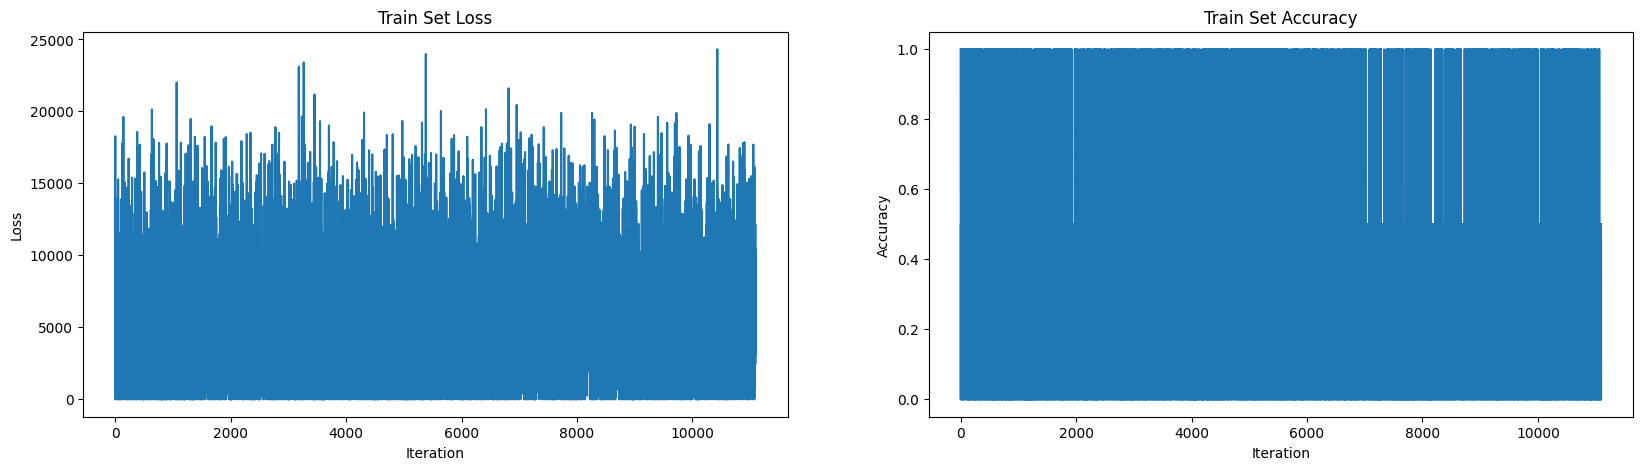

In [59]:
import matplotlib.pyplot as plt
# Plot Loss and Accuracy side-by-side
plt.figure(figsize=(20, 5), facecolor="w")

plt.subplot(1, 2, 1)
plt.plot(loss_hist, label="Train Set Loss")
plt.title("Train Set Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.subplot(1, 2, 2)
plt.plot(acc_hist, label="Train Set Accuracy")
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [60]:
# Print loss statistics
print(f"Train Loss Statistics: Min={np.min(loss_hist)} | Max={np.max(loss_hist)} | Mean={np.mean(loss_hist)}")

# Print accuracy statistics
print(f"Train Accuracy Statistics: Min={np.min(acc_hist)} | Max={np.max(acc_hist)} | Mean={np.mean(acc_hist)}")

# Print F1 Score statistics
if len(f1_hist) > 0:
    print(f"Train F1 Score Statistics: Min={np.min(f1_hist)} | Max={np.max(f1_hist)} | Mean={np.mean(f1_hist)}")

# Print how the loss evolves over time
num_iters = len(loss_hist)
window_step = 100
for train_window in range(0, num_iters, window_step):
    print(f"Train Window [{train_window}, {train_window+window_step}]: Avg. Loss={np.mean(loss_hist[train_window:train_window+window_step]):.4f}")

Train Loss Statistics: Min=0.0 | Max=24318.5 | Mean=5502.713815789473
Train Accuracy Statistics: Min=nan | Max=nan | Mean=nan
Train Window [0, 100]: Avg. Loss=4819.5000
Train Window [100, 200]: Avg. Loss=5559.3650
Train Window [200, 300]: Avg. Loss=5240.4700
Train Window [300, 400]: Avg. Loss=5329.9050
Train Window [400, 500]: Avg. Loss=4591.9700
Train Window [500, 600]: Avg. Loss=4894.0000
Train Window [600, 700]: Avg. Loss=4757.0500
Train Window [700, 800]: Avg. Loss=5603.5550
Train Window [800, 900]: Avg. Loss=5363.6250
Train Window [900, 1000]: Avg. Loss=4836.5850
Train Window [1000, 1100]: Avg. Loss=4722.5950
Train Window [1100, 1200]: Avg. Loss=5050.3700
Train Window [1200, 1300]: Avg. Loss=5748.3200
Train Window [1300, 1400]: Avg. Loss=5030.0350
Train Window [1400, 1500]: Avg. Loss=5547.8900
Train Window [1500, 1600]: Avg. Loss=6409.3250
Train Window [1600, 1700]: Avg. Loss=6314.2250
Train Window [1700, 1800]: Avg. Loss=5184.5550
Train Window [1800, 1900]: Avg. Loss=5575.5250
Tr

In [62]:
# Plot the Loss in Bokeh
from snnTorch.utils.bokeh_plots import create_line_plot
import bokeh.plotting as bplt
from bokeh.io import output_notebook, output_file

# output_notebook()   # Show the plot in the notebook

y_arrays_loss = [(loss_hist, "Loss History")]

loss_plot = create_line_plot(
    title="Training Loss", x_axis_label="Iteration", y_axis_label="Loss",
    x=list(range(len(loss_hist))), y_arrays=y_arrays_loss,
    sizing_mode="fixed",        # stretch_both
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
)

In [63]:
showPlot = True
if showPlot:
    bplt.show(loss_plot)

# Clear the Bokeh Plots
bplt.curdoc().clear()

## Output Neurons Spiking behavior to a Test Input
Let's visualize the output neurons' spiking behavior when we feed a test input to the network of each Class Type

In [64]:
# Define Loss Function for testing. No Penalty and higher tolerance.
#TODO # Is it okay to use a different loss function for testing?


loss_fn_test = SF.mse_temporal_loss(
    target_is_time=True,
    tolerance=PRED_GT_TOLERANCE * 1.5,       # Tolerance for the mse loss (in timesteps). If the output neuron spikes within this tolerance, the loss is 0
    reduction='mean',        # Average the loss across the batch
)

### Output Behavior for GT -1 -> No HFO


In [65]:
net.eval()  # Set the network to evaluation mode

test_no_hfo_input, test_no_hfo_gt = None, None
for test_batch, test_gt_batch in iter(test_loader):
    # Check if current batch has an input without an HFO
    test_no_hfo_input_idx = torch.argmin(test_gt_batch).item()
    if test_gt_batch[test_no_hfo_input_idx] < 0:
        # Found a batch without an HFO
        # Get the input data and ground truth for the test batch
        test_no_hfo_input = test_batch[test_no_hfo_input_idx]
        test_no_hfo_gt = test_gt_batch[test_no_hfo_input_idx]
        break

if test_no_hfo_input is None:
    print("No Batch without a HFO found in the Test Set!")
    exit()

# Add a batch dimension to the input data. Shape: (1, num_steps)
test_no_hfo_input = test_no_hfo_input.unsqueeze(0)
test_no_hfo_gt = test_no_hfo_gt.unsqueeze(0)

print("Found batch with Ground Truth: ", test_no_hfo_gt)
print(f"test_no_hfo_input shape = {test_no_hfo_input.shape}")
print(f"Number of UP spikes in the batch: {torch.sum(test_no_hfo_input[:, :,0])}")
print(f"Number of DN spikes in the batch: {torch.sum(test_no_hfo_input[:, :, 1])}")
print(f"test_no_hfo_gt shape = {test_no_hfo_gt.shape}")

test_no_hfo_input = test_no_hfo_input.to(device)    # Send the test data to the device
test_no_hfo_gt = test_no_hfo_gt.to(device)        # Send the test ground truth to the device

# Feed the test batch through the network
test_spks, test_mem, test_cur = net(test_no_hfo_input)

Found batch with Ground Truth:  tensor([-1.])
test_no_hfo_input shape = torch.Size([1, 180, 2])
Number of UP spikes in the batch: 12.0
Number of DN spikes in the batch: 12.0
test_no_hfo_gt shape = torch.Size([1])


No HFO Event
input_spike_times: [array([ 29,  36,  62,  77,  93, 102, 110, 121, 129, 139, 147, 153], dtype=int64), array([ 26,  32,  55,  73,  80,  96, 105, 114, 125, 131, 141, 150], dtype=int64)]


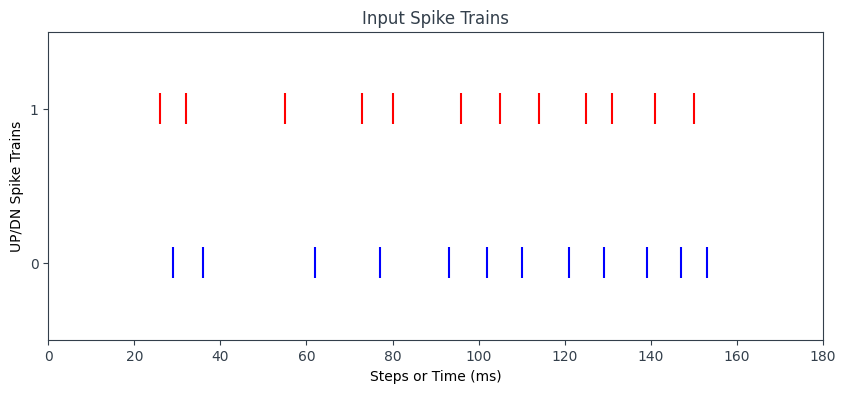

In [69]:
from snnTorch.utils.hfo import input_sample_to_spike_raster


# Creates a Figure and Axis objects
fig, ax = input_sample_to_spike_raster(
    test_no_hfo_input[0, :, :].cpu().detach().numpy(),
    test_no_hfo_gt[0].cpu().detach().numpy(),
    PRED_GT_TOLERANCE,
    verbose=True
)

# Show the plot
plt.show()

In [70]:
# Extract the output spikes of the network
out_spks = test_spks[-1]

# Calculate the Loss and Accuracy
test_no_hfo_gt = test_no_hfo_gt.clone().unsqueeze(1)   # Add num_features dimension to the ground truth tensor
loss_val = loss_fn_test(out_spks, test_no_hfo_gt.clone())   # Copy the ground truth to avoid modifying it in place
acc_val = first_spike_acc(out_spks, test_no_hfo_gt, tolerance=PRED_GT_TOLERANCE, verbose=False)

# Remove the batch dimension
out_spks = out_spks.squeeze(1)  # Resulting Shape = (num_steps, num_neurons)

print(f"out_spks Shape: {out_spks.shape}")
print(f"Number of output spikes per class: {torch.sum(out_spks[:, 0])}")
print(f"Loss: {loss_val.item()} | Accuracy: {acc_val.item()}")

IndexError: too many indices for tensor of dimension 2

The target label is: 0


ValueError: Data must be 1-dimensional, got ndarray of shape (1, 1) instead

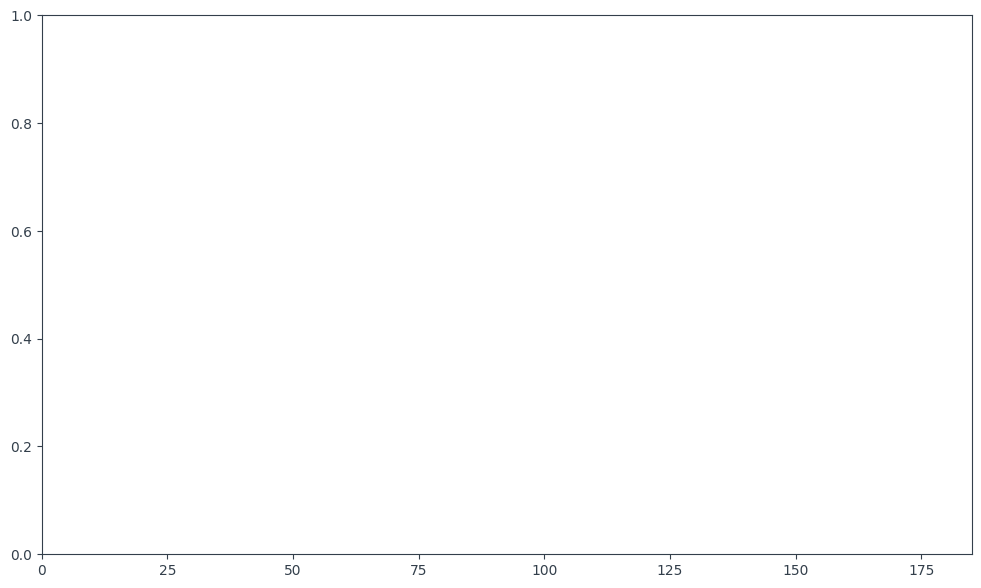

In [71]:
from IPython.display import HTML
from snntorch import spikeplot as splt

idx = 0     # Choose a sample from the batch to visualize (only 1 sample in the batch)

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))

# Define the labels for the classes
# Single Neuron -> HFO Detected
labels=['HFO']

print(f"The target label is: {int(test_no_hfo_gt.sum() > 0)}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(out_spks.detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

### Output Behavior for GT > 0 -> HFO at a given timestep


In [72]:
net.eval()  # Set the network to evaluation mode

test_hfo_input, test_hfo_gt = None, None
for test_batch, test_gt_batch in iter(test_loader):
    # Check if current batch has an input without an HFO
    test_hfo_input_idx = torch.argmax(test_gt_batch).item()
    if test_gt_batch[test_hfo_input_idx] > 0 and test_gt_batch[test_hfo_input_idx] < WINDOW_SIZE:
        # Found a batch without an HFO
        # Get the input data and ground truth for the test batch
        test_hfo_input = test_batch[test_hfo_input_idx]
        test_hfo_gt = test_gt_batch[test_hfo_input_idx]
        break

if test_hfo_input is None:
    print("No Batch with an HFO found in the Test Set!")
    exit()

# Add a batch dimension to the input data. Shape: (1, num_steps)
test_hfo_input = test_hfo_input.unsqueeze(0)
test_hfo_gt = test_hfo_gt.unsqueeze(0)

print("Found batch with Ground Truth: ", test_hfo_gt)
print(f"test_hfo_input shape = {test_hfo_input.shape}")
print(f"Number of input spikes in the batch: {torch.sum(test_hfo_input)}")

test_hfo_input = test_hfo_input.to(device)    # Send the test data to the device
test_hfo_gt = test_hfo_gt.to(device)        # Send the test ground truth to the device

# Feed the test batch through the network
test_spks, test_mem, test_cur = net(test_hfo_input)

Found batch with Ground Truth:  tensor([155.])
test_hfo_input shape = torch.Size([1, 180, 2])
Number of input spikes in the batch: 5.0


GT Interval: 135.0 to 175.0
input_spike_times: [array([10, 16, 82], dtype=int64), array([13, 66], dtype=int64)]


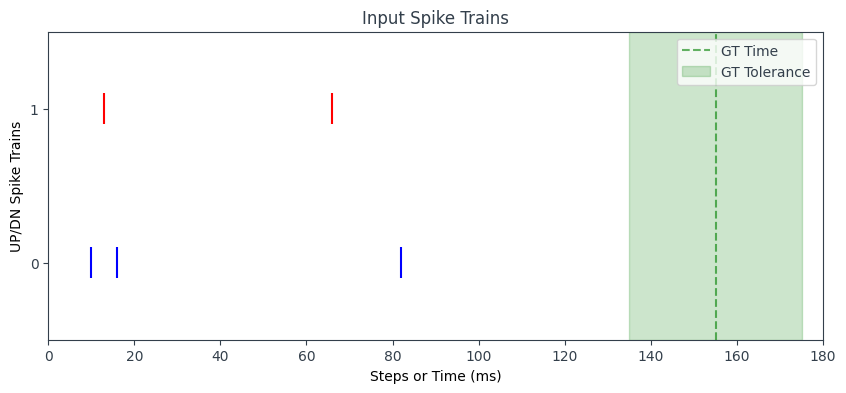

In [73]:
# Creates a Figure and Axis objects
fig, ax = input_sample_to_spike_raster(
    test_hfo_input[0, :, :].cpu().detach().numpy(),
    test_hfo_gt[0].cpu().detach().numpy(),
    PRED_GT_TOLERANCE,
    verbose=True
)

# Show the plot
plt.show()

In [74]:
# Extract the output spikes of the network
out_spks = test_spks[-1]

# Calculate the Loss and Accuracy
test_hfo_gt = test_hfo_gt.clone().unsqueeze(1)   # Add num_features dimension to the ground truth tensor
loss_val = loss_fn_test(out_spks, test_hfo_gt.clone())   # Copy the ground truth to avoid modifying it in place
acc_val = first_spike_acc(out_spks, test_hfo_gt, tolerance=PRED_GT_TOLERANCE, verbose=False)

# Remove the batch dimension
out_spks = out_spks.squeeze(1)  # Resulting Shape = (num_steps, num_neurons)

print(f"out_spks Shape: {out_spks.shape}")
print(f"Number of output spikes per class: {torch.sum(out_spks[:, 0])}")
print(f"First Out Spike Time: {torch.argmax(out_spks[:, 0])}")
print(f"Loss: {loss_val.item()} | Accuracy: {acc_val.item()}")

out_spks Shape: torch.Size([185, 1])
Number of output spikes per class: 0.0
First Out Spike Time: 0
Loss: 0.0 | Accuracy: 0.0


In [ ]:
from IPython.display import HTML
from snntorch import spikeplot as splt

idx = 0     # Choose a sample from the batch to visualize (only 1 sample in the batch)

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))

print(f"The target label is: {test_hfo_gt.sum() > 0}")

# Define the labels for the classes
# Single Neuron -> HFO Detected
labels=['HFO']

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(out_spks.detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

## Show the Trained Network Parameters
Show the trained parameters and calculate the parameter difference

In [ ]:
# Display the network architecture
total_params = 0    # Accumulator for the total params in the network
# Iterate through the layers of the network
for idx, (name, param) in enumerate(net.named_parameters()):
    untrained_param = untrained_params[idx]

    # print("param: ", param)
    if param.shape == torch.Size([]):
        print(f"Scalar Param ({name}) | Shape={param.shape} | Param Diff: {torch.sum(torch.abs(param - untrained_param)).item()} | Value={param} \n")
    elif len(param.shape) == 1:
        print(f"Vector Param ({name}) | Shape={param.shape} | Param Diff: {torch.sum(torch.abs(param - untrained_param)).item()} | Value={param} \n")
    else:
        print(f"Tensor Param ({name}) | Shape={param.shape}. Total={param.numel()} | Param Diff: {torch.sum(torch.abs(param - untrained_param)).item()} | Preview: {param[:8, :8]}\n")

    # Add the number of parameters in the layer to the total
    total_params += param.numel()

# Print the total number of parameters in the network
print(f"Total Parameters: {total_params}")

In [ ]:
# Save the trained network to a file
SAVE_TRAINED_NETWORK = False
prefix="test_mesquita"
if SAVE_TRAINED_NETWORK:
    os.makedirs("./out",exist_ok=True)  # Create the output directory if it doesn't exist 
    torch.save(net.state_dict(), f"./out/{prefix}_trained_net_loss.pth") # trained_net_loss_penalty.pth

## Test the Network on the Test Set
#### Load a Trained Network Model for Testing

In [ ]:
# Save the trained network to a file
SAVE_TRAINED_NETWORK = False
if SAVE_TRAINED_NETWORK:
    torch.save(net.state_dict(), f"./out/{prefix}_trained_net_loss.pth") # trained_net_loss_penalty.pth

In [ ]:
# Test the network on the entire test set

test_loss_hist = []         # History of the test loss
test_acc_hist = []          # History of the test accuracy
verbose_training = False    # For debugging purposes
max_test_iter = None        # Maximum number of iterations to test the network

# Test Training Loop
with torch.no_grad():
    iter_counter = 0                    # Counter for the iterations
    for data, targets in iter(test_loader):
        data = data.to(device)          # Send the data to the device (GPU or CPU)
        targets = targets.to(device)    # Send the targets to the device (GPU or CPU)

        # Perform a training step
        loss_val, acc_val = forward_step(data, targets, is_train=False, verbose=False)
        
        # Store the Loss History
        test_loss_hist.append(loss_val)
        # Append the accuracy to the accuracy history
        test_acc_hist.append(acc_val)
        
        # Print if target has at least 1 spike
        if verbose_training and torch.sum(targets) > 0:
            print(f"Epoch: {epoch} | Iteration: {iter_counter} has a Channel Burst!")


        # Print Train/Test Loss/Accuracy
        if iter_counter % 50 == 0:
            tr_utils.test_printer(
                iter_counter,
                loss_val, acc_val
            )

        iter_counter += 1       # Increment the iteration counter

        if max_test_iter and iter_counter > max_test_iter:
            break   # Stop the training loop

In [ ]:

# Plot Loss and Accuracy side-by-side
plt.figure(figsize=(20, 5), facecolor="w")

plt.subplot(1, 2, 1)
plt.plot(test_loss_hist, label="Test Set Loss")
plt.title("Test Set Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label="Test Set Accuracy")
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Print loss statistics
print(f"Test Loss Statistics: Min={np.min(test_loss_hist)} | Max={np.max(test_loss_hist)} | Mean={np.mean(test_loss_hist)}")

# Print accuracy statistics
print(f"Test Accuracy Statistics: Min={np.min(test_acc_hist)} | Max={np.max(test_acc_hist)} | Mean={np.mean(test_acc_hist)}")